In [1]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/data1/practical-sose23/castellvi/castellvi_prediction/bids')
sys.path.append('/u/home/ank/3D-Castellvi-Prediction/src')
import torch
import os
import argparse
import json
import re
from utils._prepare_data import DataHandler, read_config
from utils._get_model import *
from modules.DenseNetModule import DenseNet
from modules.ResNetModule import ResNet
from dataset.VerSe import *
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



####################################
/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/u/home/

2023-07-03 17:05:14,159 - Created a temporary directory at /tmp/tmp7ltd2wzz
2023-07-03 17:05:14,161 - Writing /tmp/tmp7ltd2wzz/_remote_module_non_scriptable.py


In [2]:
def load_model(path, params):
    checkpoint = torch.load(path)
    if params.model == 'densenet':
        model = DenseNet(opt=params, num_classes= 3, data_size = (128,86,136), data_channel=1)
    elif params.model == 'resnet' or params.model == 'pretrained_resnet':
        print('resnet')
        model = ResNet(opt=params, num_classes = 3, data_size = (128,86,136), data_channel=1)
    if params.weighted_loss:
        new_state_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model.state_dict()}
        #net = nn.DataParallel(net, device_ids=)
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(checkpoint['state_dict'])
    return model

In [3]:
def get_best_model_paths(dir_path):
    best_model_paths = []
    for root, dirs, files in os.walk(dir_path):
        if files:  # if there are files in the directory
            # Extract validation loss from file name and choose the file with the smallest loss
            best_model_file = min(files, key=lambda f: float(re.search(r'val_loss=(\d+\.\d+)', f).group(1)))
            best_model_paths.append(os.path.join(root, best_model_file))
    return best_model_paths

In [5]:
parser = argparse.ArgumentParser(description='Training settings')
parser.add_argument('--data_root', nargs='+', default=['/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/dataset-verse19', '/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/dataset-verse20'])
parser.add_argument('--data_types', nargs='+', default=['rawdata', 'derivatives'])
parser.add_argument('--img_types', nargs='+', default=['ct', 'subreg', 'cortex'])
parser.add_argument('--master_list', default='/data1/practical-sose23/castellvi/team_repo/3D-Castellvi-Prediction/src/dataset/VerSe_masterlist_V4.xlsx')
parser.add_argument('--classification_type', default='right_side')
parser.add_argument('--castellvi_classes', nargs='+', default=['1a', '1b', '2a', '2b', '3a', '3b', '4', '0'])
parser.add_argument('--model', default='densenet')
parser.add_argument('--phase', default='train')
parser.add_argument('--scheduler', default='ReduceLROnPlateau')
parser.add_argument('--optimizer', default='AdamW')
parser.add_argument('--learning_rate', type=float, default=0.0001)
parser.add_argument('--weight_decay', type=float, default=0.0001)
parser.add_argument('--total_iterations', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--num_workers', type=int, default=0)
parser.add_argument('--save_intervals', type=int, default=10)
parser.add_argument('--n_epochs', type=int, default=1)
parser.add_argument('--resume_path', default='')
parser.add_argument('--experiments', default='/u/home/ank/3D-Castellvi-Prediction/experiments')
parser.add_argument('--gpu_id', default='3')
parser.add_argument('--n_devices', type=int, default=1)
parser.add_argument('--manual_seed', type=int, default=1)
parser.add_argument('--num_classes', type=int, default=3)
parser.add_argument('--port', type=int, default=1999)
parser.add_argument('--model_type', type=str, default='')
parser.add_argument('--rotate_range', type=int, default=10)
parser.add_argument('--shear_range', type=float, default=0.2)
parser.add_argument('--translate_range', type=float, default=0.15)
parser.add_argument('--scale_range', nargs='+', default=[0.9, 1.1])
parser.add_argument('--aug_prob', type=float, default=0.5)
parser.add_argument('--use_seg', action='store_true')
parser.add_argument('--no_cuda', action='store_true')
parser.add_argument('--weighted_sample', action='store_true')
parser.add_argument('--weighted_loss', action='store_true')
#parser.add_argument('--flip_all', action='store_true')
parser.add_argument('--cross_validation', action='store_true')
parser.add_argument('--use_bin_seg', action='store_true')
parser.add_argument('--use_zero_out', action='store_true')
parser.add_argument('--gradual_freezing', action='store_true')
parser.add_argument('--elastic_transform', action='store_true')
parser.add_argument('--version_no', type=int, default=0)
args, unknown = parser.parse_known_args()


In [6]:
ckpt_path = args.experiments + '/baseline_models/' + args.model + '/best_models/version_' + str(args.version_no) 
best_model = os.listdir(ckpt_path)[0]
best_model_path = os.path.join(ckpt_path, best_model)

model = load_model(path = best_model_path, params = args)

DenseNet loaded with 3 classes, data_size (128, 86, 136) and 1 channel


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def get_layer_names(model):
    layer_names = []
    for name, _ in model.named_parameters():
        # Split the name by '.' and keep the first part
        layer_name = name
        if layer_name not in layer_names:
            layer_names.append(layer_name)
    return layer_names

In [9]:
layer_names = get_layer_names(model)

In [10]:
print(layer_names)

['network.features.conv0.weight', 'network.features.norm0.weight', 'network.features.norm0.bias', 'network.features.denseblock1.denselayer1.layers.norm1.weight', 'network.features.denseblock1.denselayer1.layers.norm1.bias', 'network.features.denseblock1.denselayer1.layers.conv1.weight', 'network.features.denseblock1.denselayer1.layers.norm2.weight', 'network.features.denseblock1.denselayer1.layers.norm2.bias', 'network.features.denseblock1.denselayer1.layers.conv2.weight', 'network.features.denseblock1.denselayer2.layers.norm1.weight', 'network.features.denseblock1.denselayer2.layers.norm1.bias', 'network.features.denseblock1.denselayer2.layers.conv1.weight', 'network.features.denseblock1.denselayer2.layers.norm2.weight', 'network.features.denseblock1.denselayer2.layers.norm2.bias', 'network.features.denseblock1.denselayer2.layers.conv2.weight', 'network.features.denseblock1.denselayer3.layers.norm1.weight', 'network.features.denseblock1.denselayer3.layers.norm1.bias', 'network.feature

In [11]:
conv_layers_list = []
for i in range(len(layer_names)):
    layer = layer_names[i]
    if 'conv' not in layer:
        continue
    else:
        conv_layers_list.append(layer)
    print(i , layer)

0 network.features.conv0.weight
5 network.features.denseblock1.denselayer1.layers.conv1.weight
8 network.features.denseblock1.denselayer1.layers.conv2.weight
11 network.features.denseblock1.denselayer2.layers.conv1.weight
14 network.features.denseblock1.denselayer2.layers.conv2.weight
17 network.features.denseblock1.denselayer3.layers.conv1.weight
20 network.features.denseblock1.denselayer3.layers.conv2.weight
23 network.features.denseblock1.denselayer4.layers.conv1.weight
26 network.features.denseblock1.denselayer4.layers.conv2.weight
29 network.features.denseblock1.denselayer5.layers.conv1.weight
32 network.features.denseblock1.denselayer5.layers.conv2.weight
35 network.features.denseblock1.denselayer6.layers.conv1.weight
38 network.features.denseblock1.denselayer6.layers.conv2.weight
41 network.features.transition1.conv.weight
44 network.features.denseblock2.denselayer1.layers.conv1.weight
47 network.features.denseblock2.denselayer1.layers.conv2.weight
50 network.features.denseblock

In [12]:
print(len(conv_layers_list))

168


In [13]:
from torchsummary import summary
summary(model, (1, 128, 86, 136))

Layer (type:depth-idx)                   Output Shape              Param #
├─DenseNet169: 1-1                       [-1, 3]                   --
|    └─Sequential: 2-1                   [-1, 1664, 4, 2, 4]       --
|    |    └─Conv3d: 3-1                  [-1, 64, 64, 43, 68]      21,952
|    |    └─BatchNorm3d: 3-2             [-1, 64, 64, 43, 68]      128
|    |    └─ReLU: 3-3                    [-1, 64, 64, 43, 68]      --
|    |    └─MaxPool3d: 3-4               [-1, 64, 32, 22, 34]      --
|    |    └─_DenseBlock: 3-5             [-1, 256, 32, 22, 34]     777,408
|    |    └─_Transition: 3-6             [-1, 128, 16, 11, 17]     33,280
|    |    └─_DenseBlock: 3-7             [-1, 512, 16, 11, 17]     1,804,416
|    |    └─_Transition: 3-8             [-1, 256, 8, 5, 8]        132,096
|    |    └─_DenseBlock: 3-9             [-1, 1280, 8, 5, 8]       6,675,456
|    |    └─_Transition: 3-10            [-1, 640, 4, 2, 4]        821,760
|    |    └─_DenseBlock: 3-11            [-1, 1

Layer (type:depth-idx)                   Output Shape              Param #
├─DenseNet169: 1-1                       [-1, 3]                   --
|    └─Sequential: 2-1                   [-1, 1664, 4, 2, 4]       --
|    |    └─Conv3d: 3-1                  [-1, 64, 64, 43, 68]      21,952
|    |    └─BatchNorm3d: 3-2             [-1, 64, 64, 43, 68]      128
|    |    └─ReLU: 3-3                    [-1, 64, 64, 43, 68]      --
|    |    └─MaxPool3d: 3-4               [-1, 64, 32, 22, 34]      --
|    |    └─_DenseBlock: 3-5             [-1, 256, 32, 22, 34]     777,408
|    |    └─_Transition: 3-6             [-1, 128, 16, 11, 17]     33,280
|    |    └─_DenseBlock: 3-7             [-1, 512, 16, 11, 17]     1,804,416
|    |    └─_Transition: 3-8             [-1, 256, 8, 5, 8]        132,096
|    |    └─_DenseBlock: 3-9             [-1, 1280, 8, 5, 8]       6,675,456
|    |    └─_Transition: 3-10            [-1, 640, 4, 2, 4]        821,760
|    |    └─_DenseBlock: 3-11            [-1, 1

In [22]:
import nibabel as nib

In [41]:
layer_params = dict(model.named_parameters())[conv_layers_list[-1]]
filters = layer_params.data.cpu().numpy()
print(layer_params)

Parameter containing:
tensor([[[[[-2.0133e-02, -2.5855e-02,  2.5115e-02],
           [-7.6919e-03, -1.6432e-02, -3.0623e-02],
           [ 2.8959e-02, -1.6480e-03,  3.6801e-02]],

          [[ 3.2205e-02, -2.8121e-02, -1.1213e-02],
           [ 8.4940e-03, -1.7001e-02, -1.2521e-02],
           [-1.9982e-02,  2.4645e-03,  1.3893e-02]],

          [[-4.1640e-04,  2.2728e-03,  3.9371e-03],
           [ 7.9421e-03,  1.2390e-02, -1.8449e-03],
           [-3.9382e-02,  5.9268e-03, -2.3856e-02]]],


         [[[ 8.1534e-03,  2.5303e-02,  1.7626e-02],
           [ 4.2072e-03,  2.1965e-02,  6.1178e-02],
           [ 2.3719e-02, -2.4829e-03,  1.3907e-03]],

          [[ 1.2374e-02,  3.8264e-03,  1.3192e-03],
           [ 1.6599e-02, -3.2005e-02, -6.1312e-02],
           [ 6.7086e-03,  9.0652e-03,  1.3557e-02]],

          [[ 6.0106e-02,  2.8975e-02, -7.0543e-03],
           [-3.0985e-03,  2.6263e-02,  1.2852e-02],
           [-3.3433e-02,  1.6758e-02, -3.0296e-02]]],


         [[[ 4.4366e-03, -

In [42]:
img = nib.Nifti1Image(filters, np.eye(4))  # Use appropriate affine transformation

# Save the NIfTI file
nib.save(img, 'learned_filters.nii.gz')

In [14]:
import matplotlib.pyplot as plt
import numpy as np



def visualize_filters(model, layer_name, nrows, ncols):
    # Get the parameters of the specified layer
    layer_params = dict(model.named_parameters())[layer_name]

    # Get the weights of the convolutional layer
    filters = layer_params.data.cpu().numpy()

    # Calculate the number of filters and the size of each filter
    num_filters, _, filter_size, _, _ = filters.shape
    print(filter_size)

    # Calculate the number of slices to display per filter
    num_slices = filter_size

    # Create a figure to visualize the filters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    # Plot each filter slice
    for i, ax in enumerate(axes.flat):
        if i < num_filters * num_slices:
            # Calculate the filter index and slice index
            filter_idx = i // num_slices
            slice_idx = i % num_slices

            # Normalize the filter weights to [0, 1]
            filter_weights = filters[filter_idx, 0, slice_idx]
            min_val = np.min(filter_weights)
            max_val = np.max(filter_weights)
            normalized_weights = (filter_weights - min_val) / (max_val - min_val + 1e-8)

            # Plot the filter weights
            ax.imshow(normalized_weights, cmap='gray')
            ax.axis('off')

    # Adjust the spacing between subplots
    fig.tight_layout()

7


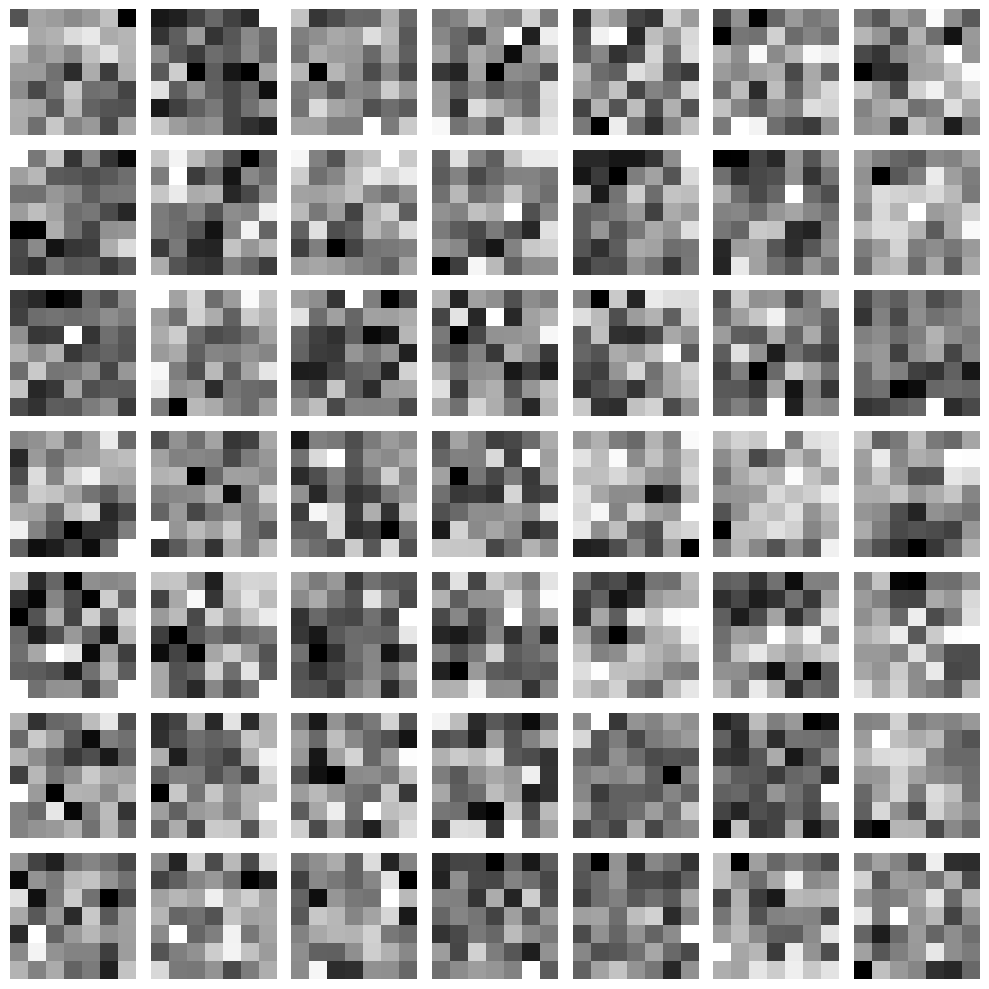

In [15]:
# Visualize the filters in the first convolutional layer of the first dense block
visualize_filters(model, conv_layers_list[0], nrows=7, ncols=7)

# Show the plot
plt.show()

In [16]:
conv_layers = [module for module in model.modules() if isinstance(module, torch.nn.Conv3d)]

# Extract the learned filters from the convolutional layers
learned_filters = [layer.weight.data for layer in conv_layers]

print(len(learned_filters))

168


In [18]:
print(learned_filters)

[tensor([[[[[-5.6664e-02,  9.3376e-02,  7.7713e-02,  ...,  7.4050e-02,
             1.4475e-01, -2.1434e-01],
           [ 2.6241e-01,  9.9718e-02,  1.1557e-01,  ...,  2.1802e-01,
             1.0541e-01,  1.2376e-01],
           [ 1.3696e-01,  5.2153e-02,  8.8688e-02,  ...,  1.4452e-01,
             2.0646e-01,  1.2113e-01],
           ...,
           [ 4.7077e-02, -7.8229e-02,  9.3396e-03,  ..., -7.2990e-03,
             4.3501e-03, -8.6939e-02],
           [ 1.0792e-01,  9.7773e-02, -4.3624e-02,  ..., -2.9647e-02,
            -5.6162e-02, -6.0494e-02],
           [ 1.0476e-01, -6.0073e-03,  1.5795e-01,  ...,  7.0747e-02,
            -7.6400e-02,  9.4850e-02]],

          [[-4.0990e-02, -3.1176e-02,  1.3451e-02,  ...,  1.0531e-02,
            -2.2648e-02,  2.5551e-01],
           [-5.3649e-03,  4.8190e-02,  1.2761e-01,  ...,  3.8728e-02,
             1.0293e-01,  6.2083e-02],
           [ 1.0682e-01,  4.3331e-02,  4.4167e-03,  ...,  4.5494e-02,
             1.0794e-01,  5.5792e-02],


In [20]:
model.children

<bound method Module.children of DenseNet(
  (network): DenseNet169(
    (features): Sequential(
      (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)

In [21]:
import monai
#from monai.networks.utils import eval_mode
from monai.transforms import (
    AddChannel, Compose, LoadImage, RandRotate90, NormalizeIntensity, RandScaleIntensity,
    Resize, ScaleIntensityRange, ToTensor, ScaleIntensity, RandShiftIntensity,CropForeground,
    RandFlip, RandSpatialCrop, ResizeWithPadOrCrop, Spacing, ThresholdIntensity, Orientation
)
from monai.metrics import compute_roc_auc

In [44]:
model.eval()

y_pred = torch.tensor([], dtype=torch.float32, device = device)
y = torch.tensor([], dtype=torch.long , device = device)

In [22]:
print(args)

Namespace(data_root=['/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/dataset-verse19', '/data1/practical-sose23/castellvi/3D-Castellvi-Prediction/data/dataset-verse20'], data_types=['rawdata', 'derivatives'], img_types=['ct', 'subreg', 'cortex'], master_list='/data1/practical-sose23/castellvi/team_repo/3D-Castellvi-Prediction/src/dataset/VerSe_masterlist_V4.xlsx', classification_type='right_side', castellvi_classes=['1a', '1b', '2a', '2b', '3a', '3b', '4', '0'], model='densenet', phase='train', scheduler='ReduceLROnPlateau', optimizer='AdamW', learning_rate=0.0001, weight_decay=0.0001, total_iterations=100, batch_size=8, num_workers=0, save_intervals=10, n_epochs=1, resume_path='', experiments='/u/home/ank/3D-Castellvi-Prediction/experiments', gpu_id='3', n_devices=1, manual_seed=1, num_classes=3, port=1999, model_type='', rotate_range=10, shear_range=0.2, translate_range=0.15, scale_range=[0.9, 1.1], aug_prob=0.5, use_seg=False, no_cuda=False, weighted_sample=False, we

In [23]:
def get_processor():
    processor = DataHandler(master_list = args.master_list,
                        dataset = args.data_root,
                        data_types = args.data_types,
                        image_types = args.img_types
                    )
    return processor

In [24]:
print(args.master_list)

/data1/practical-sose23/castellvi/team_repo/3D-Castellvi-Prediction/src/dataset/VerSe_masterlist_V4.xlsx


In [25]:
processor = get_processor()

[!] Unknown format seg-ano in file sub-verse649_dir-sag_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] "template" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] "sacrum" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] Unknown format subreg in file verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano.nii.gz
[!] "verse549" is not a valid key/value pair. Expected "KEY-VALUE" in verse549_CT-iso_seg-ano.nii.gz


In [26]:
records = processor.verse_records

In [27]:
print(records)

[{'dataset': 'verse', 'subject': 'verse004', 'split': None, 'dataset_split': 'train', 'flip': 0, 'raw_file': sub-verse004_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse004_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse004_seg-vertsac_ctd.['json']	 parent = derivatives, 'castellvi': '0', 'last_l': 'L5', 'side': nan}, {'dataset': 'verse', 'subject': 'verse004', 'split': None, 'dataset_split': 'train', 'flip': 1, 'raw_file': sub-verse004_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse004_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse004_seg-vertsac_ctd.['json']	 parent = derivatives, 'castellvi': '0', 'last_l': 'L5', 'side': nan}, {'dataset': 'verse', 'subject': 'verse005', 'split': None, 'dataset_split': 'test', 'flip': 1, 'raw_file': sub-verse005_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse005_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse005_seg-vertsac_ctd.['json']	 parent = derivatives

In [28]:
from dataset.VerSe import VerSe

In [29]:
train_records = []
val_records = []
    # # remove recorde if their flip value is 1 and castellvi value does not contain 'a'
records = [record for record in records if record["flip"] == 1 and (record["castellvi"]!='2a' or record["castellvi"]!='3a')]
print("----------------------------------------------------------------------------------")
print(f"Total records after removing non-flipped records: {len(records)}")
      
for record in records:
    if record["dataset_split"] == "train":
        train_records.append(record)
    elif record["dataset_split"] == "val":
        val_records.append(record)
    elif record["dataset_split"] == "test":
        val_records.append(record)
        val_records.append(record)
    else:
        raise ValueError("Invalid split value {} in record: {}".format(record["dataset_split"], record["subject"]))
    

train_dataset = VerSe(args, processor, train_records, training=True)
val_dataset = VerSe(args, processor, val_records, training=False)



----------------------------------------------------------------------------------
Total records after removing non-flipped records: 277


In [30]:
print(train_records)

[{'dataset': 'verse', 'subject': 'verse004', 'split': None, 'dataset_split': 'train', 'flip': 1, 'raw_file': sub-verse004_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse004_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse004_seg-vertsac_ctd.['json']	 parent = derivatives, 'castellvi': '0', 'last_l': 'L5', 'side': nan}, {'dataset': 'verse', 'subject': 'verse006', 'split': None, 'dataset_split': 'train', 'flip': 1, 'raw_file': sub-verse006_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse006_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse006_seg-vertsac_ctd.['json']	 parent = derivatives, 'castellvi': '0', 'last_l': 'L5', 'side': nan}, {'dataset': 'verse', 'subject': 'verse008', 'split': None, 'dataset_split': 'train', 'flip': 1, 'raw_file': sub-verse008_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse008_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse008_seg-vertsac_ctd.['json']	 parent = derivative

In [31]:
print(train_records[0])

{'dataset': 'verse', 'subject': 'verse004', 'split': None, 'dataset_split': 'train', 'flip': 1, 'raw_file': sub-verse004_ct.['nii.gz']	 parent = rawdata, 'seg_file': sub-verse004_seg-vertsac_msk.['nii.gz']	 parent = derivatives, 'ctd_file': sub-verse004_seg-vertsac_ctd.['json']	 parent = derivatives, 'castellvi': '0', 'last_l': 'L5', 'side': nan}


In [32]:
data_size = (128,86,136)

In [33]:
img = processor._get_cutout(train_records[0], return_seg = args.use_seg, max_shape= data_size)


In [34]:
print(img)

[[[  -62.38814     -80.653465   -118.80256   ...     0.
       0.            0.       ]
  [ -193.04074    -173.79523    -124.01766   ...     0.
       0.            0.       ]
  [ -105.21283    -102.89006    -102.89516   ...     0.
       0.            0.       ]
  ...
  [  -17.46553     -56.27669     -88.83411   ...     0.
       0.            0.       ]
  [ -123.66694    -137.28482    -133.548     ...     0.
       0.            0.       ]
  [  -18.24965     -57.807964    -92.96702   ...     0.
       0.            0.       ]]

 [[  -78.706924   -108.9082     -104.65258   ...     0.
       0.            0.       ]
  [  -59.935013    -26.231659     -5.0423813 ...     0.
       0.            0.       ]
  [  -84.995674    -79.775856    -61.98341   ...     0.
       0.            0.       ]
  ...
  [ -233.6844     -144.59872     -42.712597  ...     0.
       0.            0.       ]
  [  -89.467255    -79.93265     -78.11487   ...     0.
       0.            0.       ]
  [  -90.13732    

In [114]:
print(img.shape)

(128, 86, 136)


In [35]:
label = str(record["castellvi"]) # 0, 2a, 2b, 3a, 3b, 4

In [36]:
print(label)

0


In [37]:
image1 = img[np.newaxis,np.newaxis, ...]
image2 = image1.astype(np.float32)
image3 = torch.from_numpy(image2)
image4 = image3.to(device)
image5 = image4.float()

In [38]:
print(image5)
print(type(image5))
print(image5.shape)

tensor([[[[[  -62.3881,   -80.6535,  -118.8026,  ...,     0.0000,
                0.0000,     0.0000],
           [ -193.0407,  -173.7952,  -124.0177,  ...,     0.0000,
                0.0000,     0.0000],
           [ -105.2128,  -102.8901,  -102.8952,  ...,     0.0000,
                0.0000,     0.0000],
           ...,
           [  -17.4655,   -56.2767,   -88.8341,  ...,     0.0000,
                0.0000,     0.0000],
           [ -123.6669,  -137.2848,  -133.5480,  ...,     0.0000,
                0.0000,     0.0000],
           [  -18.2496,   -57.8080,   -92.9670,  ...,     0.0000,
                0.0000,     0.0000]],

          [[  -78.7069,  -108.9082,  -104.6526,  ...,     0.0000,
                0.0000,     0.0000],
           [  -59.9350,   -26.2317,    -5.0424,  ...,     0.0000,
                0.0000,     0.0000],
           [  -84.9957,   -79.7759,   -61.9834,  ...,     0.0000,
                0.0000,     0.0000],
           ...,
           [ -233.6844,  -144.5987,   -

In [39]:
with torch.no_grad():
    output_1 = model(image5)

In [40]:
print(output_1)

tensor([[-1.4030, -0.6922, -1.7456]], device='cuda:0')


In [41]:
pred_label = output_1.argmax(1).item()

In [42]:
print(pred_label)

1


In [43]:
the_slice = image5.shape[-1] // 2

In [44]:
print(image5.shape)

torch.Size([1, 1, 128, 86, 136])


In [211]:
print(the_slice)

68


In [110]:
print(image5)

tensor([[[[[  -62.3881,   -80.6535,  -118.8026,  ...,     0.0000,
                0.0000,     0.0000],
           [ -193.0407,  -173.7952,  -124.0177,  ...,     0.0000,
                0.0000,     0.0000],
           [ -105.2128,  -102.8901,  -102.8952,  ...,     0.0000,
                0.0000,     0.0000],
           ...,
           [  -17.4655,   -56.2767,   -88.8341,  ...,     0.0000,
                0.0000,     0.0000],
           [ -123.6669,  -137.2848,  -133.5480,  ...,     0.0000,
                0.0000,     0.0000],
           [  -18.2496,   -57.8080,   -92.9670,  ...,     0.0000,
                0.0000,     0.0000]],

          [[  -78.7069,  -108.9082,  -104.6526,  ...,     0.0000,
                0.0000,     0.0000],
           [  -59.9350,   -26.2317,    -5.0424,  ...,     0.0000,
                0.0000,     0.0000],
           [  -84.9957,   -79.7759,   -61.9834,  ...,     0.0000,
                0.0000,     0.0000],
           ...,
           [ -233.6844,  -144.5987,   -

In [183]:
image7 = image5.detach().cpu().numpy()[..., 5]

In [184]:
image8 = img[..., 5]

In [185]:
print(image8)

[[ -43.553448  -52.782425  -43.797073 ...  -11.682289 -119.19613
   -81.66504 ]
 [  25.624224  -41.433098  -90.31957  ...  -97.866806  -89.8989
    -7.892699]
 [ -94.59895   -57.084732  -71.38355  ...  -13.103944  -16.064047
   -25.894144]
 ...
 [-960.88385  -966.3805   -959.47144  ...  -26.526417  -28.748095
    12.369452]
 [-944.9065   -932.06946  -941.4314   ...  -49.738987   47.954597
  -183.13498 ]
 [-975.434    -971.0829   -934.40625  ...  -52.568935  -96.08448
    77.835266]]


In [164]:
print(image7.shape)

(1, 1, 128, 86)


In [165]:
print(image7)

[[[[ -43.553448  -52.782425  -43.797073 ...  -11.682289 -119.19613
     -81.66504 ]
   [  25.624224  -41.433098  -90.31957  ...  -97.866806  -89.8989
      -7.892699]
   [ -94.59895   -57.084732  -71.38355  ...  -13.103944  -16.064047
     -25.894144]
   ...
   [-960.88385  -966.3805   -959.47144  ...  -26.526417  -28.748095
      12.369452]
   [-944.9065   -932.06946  -941.4314   ...  -49.738987   47.954597
    -183.13498 ]
   [-975.434    -971.0829   -934.40625  ...  -52.568935  -96.08448
      77.835266]]]]


In [166]:
campp = monai.visualize.GradCAMpp(nn_module = model, target_layers = "network.features.denseblock4.denselayer32.layers.conv2", )
win_size = (128, 86, 136)
print("original feature shape", campp.feature_map_size([1, 1] + list(win_size), device) )
print("upsampled feature shape", [1, 1] + list(win_size), device)

original feature shape torch.Size([1, 1, 4, 2, 4])
upsampled feature shape [1, 1, 128, 86, 136] cuda


In [167]:
campp_result = campp( x=image5 , class_idx=None)

In [168]:
print(campp_result)

tensor([[[[[0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           [0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           [0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.7635, 0.7635, 0.7635,  ..., 0.9937, 0.9937, 0.9937],
           [0.7635, 0.7635, 0.7635,  ..., 0.9937, 0.9937, 0.9937],
           [0.7635, 0.7635, 0.7635,  ..., 0.9937, 0.9937, 0.9937]],

          [[0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           [0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           [0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.7635, 0.7635, 0.7635,  ..., 0.9937, 0.9937, 0.9937],
           [0.7635, 0.7635, 0.7635,  ..., 0.9937, 0.9937, 0.9937],
           [0.7635, 0.7635, 0.7635,  ..., 0.9937, 0.9937, 0.9937]],

          [[0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           [0.9503, 0.9503, 0.9503,  ..., 1.0000, 1.0000, 1.0000],
           [0.9503, 0.9503

In [169]:
normal_campp_result = campp_result[..., 5]

In [170]:
print(normal_campp_result)

tensor([[[[0.9503, 0.9503, 0.9503,  ..., 0.7635, 0.7635, 0.7635],
          [0.9503, 0.9503, 0.9503,  ..., 0.7635, 0.7635, 0.7635],
          [0.9503, 0.9503, 0.9503,  ..., 0.7635, 0.7635, 0.7635],
          ...,
          [0.4844, 0.4844, 0.4844,  ..., 0.7187, 0.7187, 0.7187],
          [0.4844, 0.4844, 0.4844,  ..., 0.7187, 0.7187, 0.7187],
          [0.4844, 0.4844, 0.4844,  ..., 0.7187, 0.7187, 0.7187]]]],
       device='cuda:0')


In [171]:
numpy_camp_result = campp_result.detach().cpu().numpy()[..., 5]

In [172]:
print(numpy_camp_result)

[[[[0.9502526  0.9502526  0.9502526  ... 0.76346314 0.76346314
    0.76346314]
   [0.9502526  0.9502526  0.9502526  ... 0.76346314 0.76346314
    0.76346314]
   [0.9502526  0.9502526  0.9502526  ... 0.76346314 0.76346314
    0.76346314]
   ...
   [0.48443425 0.48443425 0.48443425 ... 0.7187419  0.7187419
    0.7187419 ]
   [0.48443425 0.48443425 0.48443425 ... 0.7187419  0.7187419
    0.7187419 ]
   [0.48443425 0.48443425 0.48443425 ... 0.7187419  0.7187419
    0.7187419 ]]]]


In [173]:
print(numpy_camp_result.shape)

(1, 1, 128, 86)


In [174]:
numpy_camp_result

array([[[[0.9502526 , 0.9502526 , 0.9502526 , ..., 0.76346314,
          0.76346314, 0.76346314],
         [0.9502526 , 0.9502526 , 0.9502526 , ..., 0.76346314,
          0.76346314, 0.76346314],
         [0.9502526 , 0.9502526 , 0.9502526 , ..., 0.76346314,
          0.76346314, 0.76346314],
         ...,
         [0.48443425, 0.48443425, 0.48443425, ..., 0.7187419 ,
          0.7187419 , 0.7187419 ],
         [0.48443425, 0.48443425, 0.48443425, ..., 0.7187419 ,
          0.7187419 , 0.7187419 ],
         [0.48443425, 0.48443425, 0.48443425, ..., 0.7187419 ,
          0.7187419 , 0.7187419 ]]]], dtype=float32)

In [175]:
import cv2
# Overlay Original image and GradCAM heatmap
def superimposed_image_def(cam_img, original_img, alpha = 0.6):
    original_img = original_img[0,0,:,:] 
    print('original_img shape:', original_img.shape)
    print('original_img data type:', original_img.dtype)
    # Make 1-channel image to 3-channel : To overlay this image with the heatmap (JET colormap = 3-channels)
    original_img = cv2.merge((original_img, original_img, original_img))
    cam_img = cam_img[0,0,:,:] # Same above
    print('cam_img shape:', cam_img.shape)
    print('cam_img data type:', cam_img.dtype)
    cam_img = np.maximum(cam_img, 0)


    # Convert Class Activation Map to 0 - 255
    cam_img = (cam_img - cam_img.min()) / (
               cam_img.max() - cam_img.min()
    )
    cam_img = np.uint8(255 * cam_img)

    # Convert to Heatmap ---- JET COLORMAP
    cam_img = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    

    superimposed_image =np.uint8(np.uint8(original_img) * alpha + cam_img * (1 - alpha))
    
    return superimposed_image

In [176]:
campp_and_img = superimposed_image_def(numpy_camp_result, image7)

original_img shape: (128, 86)
original_img data type: float32
cam_img shape: (128, 86)
cam_img data type: float32


In [177]:
print(campp_and_img.shape)
print(type(campp_and_img))

(128, 86, 3)
<class 'numpy.ndarray'>


In [178]:
print(f"shape of the GradCAM++ heatmap w.r.t. the slice {the_slice}: {campp_and_img.shape}" )

shape of the GradCAM++ heatmap w.r.t. the slice 68: (128, 86, 3)


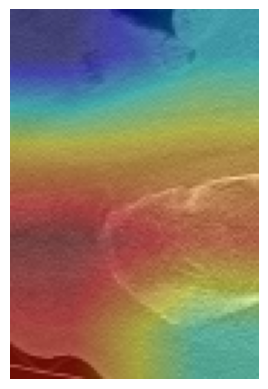

In [179]:
import matplotlib.pyplot as plt

plt.imshow(campp_and_img)
plt.axis('off')  
plt.show()